In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## 0. Environment Setup & Dependencies

Run this cell **first** to install all required libraries (including detectron2, roma, and system dependencies), configure the environment for headless 3D rendering on Colab, and authenticate with Hugging Face to download the models. **Restart the runtime** if prompted after installation.

In [2]:
# 1. Clone the repository and move into the notebook directory
!git clone https://github.com/facebookresearch/sam-3d-body.git
%cd sam-3d-body/notebook

# 2. Install System Dependencies (Required for 3D rendering)
!apt-get update && apt-get install -y libgl1-mesa-glx libosmesa6-dev freeglut3-dev

# 3. Install ALL Python Dependencies explicitly
# Added 'fvcore', 'iopath', 'omegaconf', 'cloudpickle' (for Detectron2) and 'roma' (for SAM 3D Body)
!pip install fvcore iopath omegaconf cloudpickle roma pytorch-lightning pyrender opencv-python yacs scikit-image einops timm dill pandas rich hydra-core hydra-submitit-launcher hydra-colorlog pyrootutils webdataset chump networkx==3.2.1

# 4. Install Detectron2 and MoGe
# We keep --no-deps to avoid Torch version conflicts, but we installed the deps manually in step 3.
!pip install 'git+https://github.com/facebookresearch/detectron2.git@a1ce2f9' --no-build-isolation --no-deps
!pip install git+https://github.com/microsoft/MoGe.git

# 5. Install the SAM 3D Body package in editable mode
%cd ..
!pip install -e .
%cd notebook

# 6. Set environment variable for headless rendering
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

# 7. Hugging Face Authentication
from huggingface_hub import login
print("\n=== AUTHENTICATION REQUIRED ===")
print("Please enter your Hugging Face token (Write access) to download the models.")
login()

print("\nSetup complete. Please RESTART THE RUNTIME (Runtime > Restart session) before running the next cell.")

fatal: destination path 'sam-3d-body' already exists and is not an empty directory.
/content/sam-3d-body/notebook
Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.s


Setup complete. Please RESTART THE RUNTIME (Runtime > Restart session) before running the next cell.


## 1. Imports and Model Loading

In [3]:
import sys
import os

parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)

from utils import (
    setup_sam_3d_body, setup_visualizer,
    visualize_2d_results, visualize_3d_mesh, save_mesh_results,
    display_results_grid, process_image_with_mask
)

# Set up SAM 3D Body estimator
estimator = setup_sam_3d_body(hf_repo_id="facebook/sam-3d-body-dinov3")
# Set up visualizer
visualizer = setup_visualizer()

/content/sam-3d-body/sam_3d_body/models/heads/mhr_head.py:33: UserWarning: Momentum is not enabled
  warnings.warn("Momentum is not enabled")


Loading SAM 3D Body model from facebook/sam-3d-body-dinov3...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loading SAM 3D Body model...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main

missing keys in source state_dict: backbone.encoder.mask_token, head_pose.hand_pose_comps_ori, head_pose.mhr.face_expressions_model.shape_vectors, head_pose.mhr.pose_correctives_model.pose_dirs_predictor.0.sparse_indices, head_pose.mhr.pose_correctives_model.pose_dirs_predictor.0.sparse_weight, head_pose.mhr.pose_correctives_model.pose_dirs_predictor.2.weight, head_pose.mhr.character_torch.skeleton.joint_translation_offsets, head_pose.mhr.character_torch.skeleton.joint_prerotations, head_pose.mhr.character_torch.skeleton.pmi, head_pose.mhr.character_torch.skeleton.joint_parents, head_pose.mhr.character_torch.mesh.rest_vertices, head_pose.mhr.character_torch.mesh.faces, head_pose.mhr.character_torch.mesh.texcoords, head_pose.mhr.character_torch.mesh.texcoord_faces, head_pose.mhr.character_torch.parameter_transform.parameter_transform, head_pose.mhr.character_torch.parameter_transform.pose_parameters, head_pose.mhr

Loading human detector from vitdet...
########### Using human detector: ViTDet...


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading FOV estimator from moge2...
########### Using fov estimator: MoGe2...
Mask-condition inference is not supported...
Setup complete!
  Human detector: ✓
  Human segmentor: ✗ (mask inference disabled)
  FOV estimator: ✓


## 2. Process Image and Get Outputs

Processing image with SAM 3D Body...
Running object detector...


/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Found boxes: [[ 729.3197   109.74103 1529.0903  1453.1057 ]]
Running FOV estimator ...
Number of people detected: 1
Output keys for first person: ['bbox', 'focal_length', 'pred_keypoints_3d', 'pred_keypoints_2d', 'pred_vertices', 'pred_cam_t', 'pred_pose_raw', 'global_rot', 'body_pose_params', 'hand_pose_params', 'scale_params', 'shape_params', 'expr_params', 'mask', 'pred_joint_coords', 'pred_global_rots', 'lhand_bbox', 'rhand_bbox']


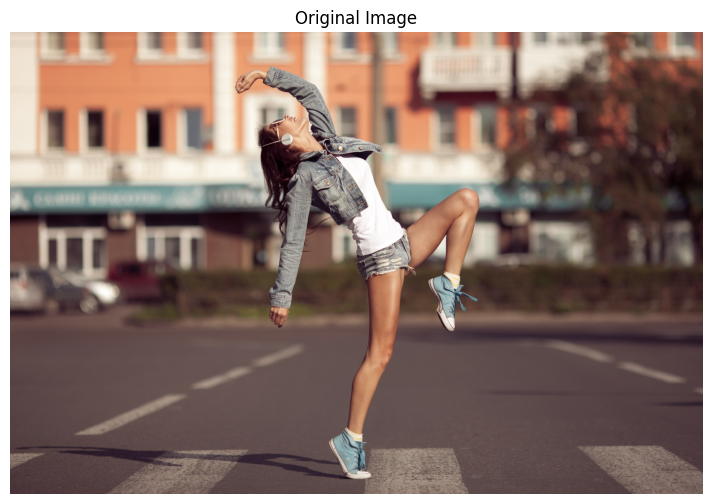

In [4]:
import cv2
import matplotlib.pyplot as plt

# Load and process the image
image_path = "images/dancing.jpg"  # Relative to notebook folder
img_cv2 = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Process the image with SAM 3D Body
print("Processing image with SAM 3D Body...")
outputs = estimator.process_one_image(image_path)

print(f"Number of people detected: {len(outputs)}")
print(f"Output keys for first person: {list(outputs[0].keys()) if outputs else 'No people detected'}")

# Display the original image
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Original Image')
plt.show()

## 3. 2D Visualization - Keypoints and Bounding Boxes

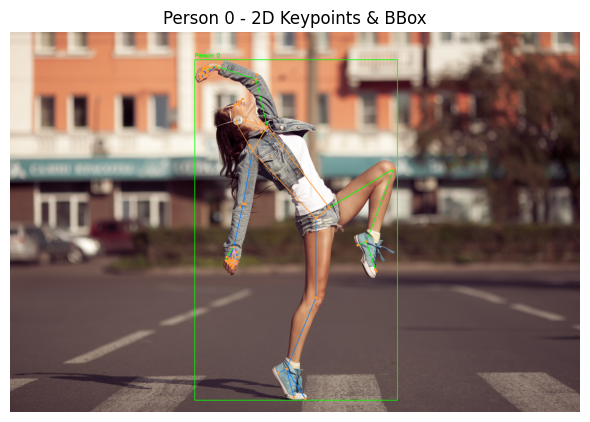

In [5]:
# Visualize 2D results using utils
if outputs:
    vis_results = visualize_2d_results(img_cv2, outputs, visualizer)

    # Display results using grid function
    titles = [f'Person {i} - 2D Keypoints & BBox' for i in range(len(vis_results))]
    display_results_grid(vis_results, titles, figsize_per_image=(6, 6))
else:
    print("No people detected in the image")

## 4. 3D Mesh Visualization - Overlay and Side View

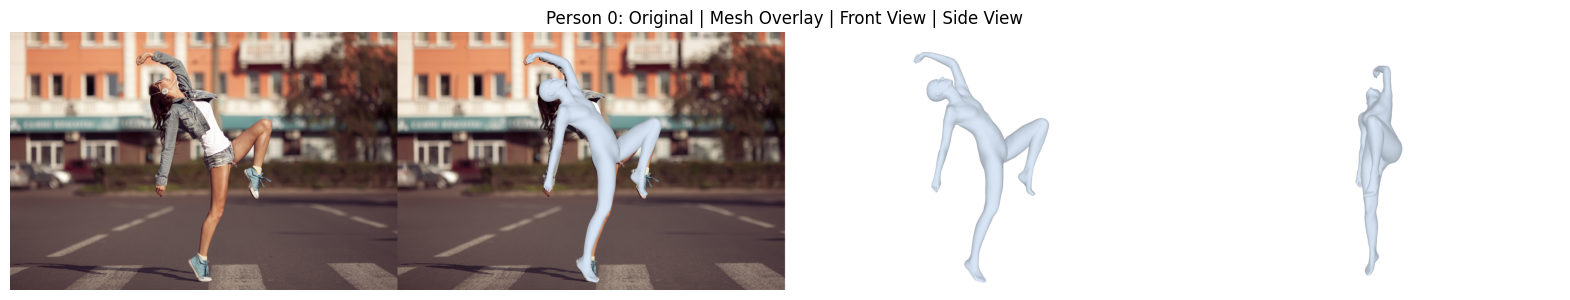

In [6]:
if outputs:
    mesh_results = visualize_3d_mesh(img_cv2, outputs, estimator.faces)

    # Display results
    for i, combined_img in enumerate(mesh_results):
        combined_rgb = cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(20, 5))
        plt.imshow(combined_rgb)
        plt.title(f'Person {i}: Original | Mesh Overlay | Front View | Side View')
        plt.axis('off')
        plt.show()
else:
    print("No people detected for 3D mesh visualization")

## 5. Save 3D Mesh Files and Results

In [7]:
if outputs:
    # Get image name without extension
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    # Create output directory
    output_dir = f"output/{image_name}"

    # Save all results (PLY meshes, overlay images, bbox images)
    ply_files = save_mesh_results(img_cv2, outputs, estimator.faces, output_dir, image_name)

    print(f"\n=== Saved Results for {image_name} ===")
    print(f"Output directory: {output_dir}")
    print(f"Number of PLY files created: {len(ply_files)}")

else:
    print("No results to save - no people detected")

Saved focal length: output/dancing/dancing_focal_length.json
Saved mesh: output/dancing/dancing_mesh_000.ply
Saved overlay: output/dancing/dancing_overlay_000.png
Saved bbox: output/dancing/dancing_bbox_000.png

=== Saved Results for dancing ===
Output directory: output/dancing
Number of PLY files created: 1


## 6. Mask-Based Inference

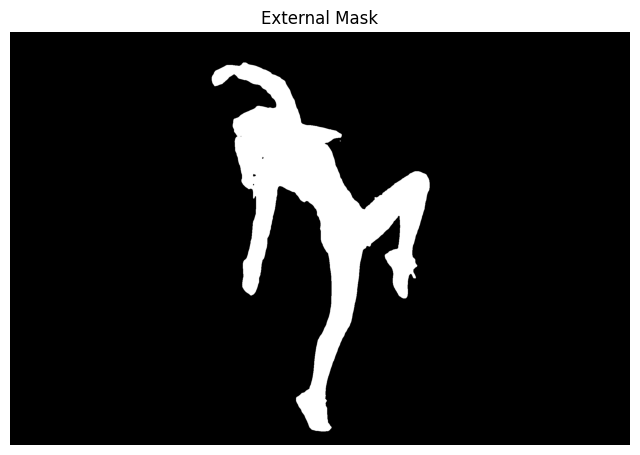

Processing image with external mask: images/dancing_mask.png
Mask shape: (1500, 2250), unique values: [  0 255]
Computed bbox from mask: [ 732.  114. 1523. 1451.]
Using provided masks: (1500, 2250)
Running FOV estimator ...


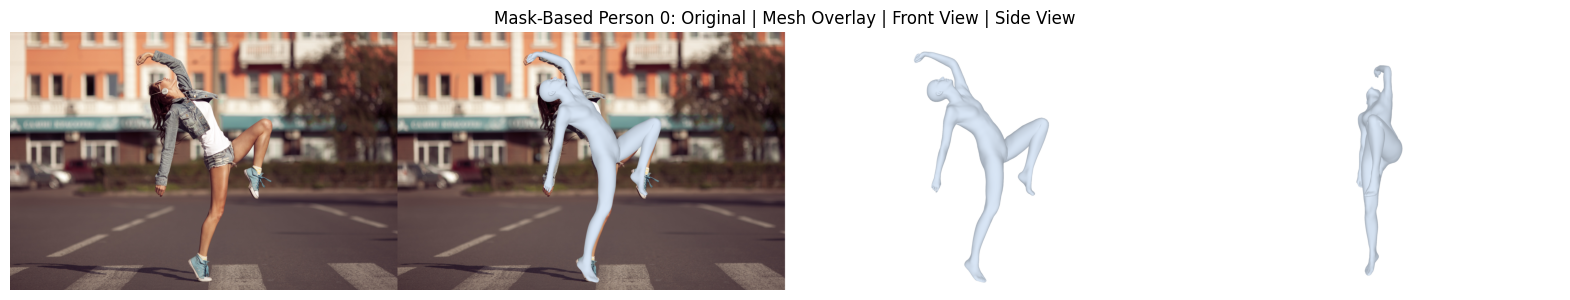

Saved focal length: output/mask_based_dancing/mask_dancing_focal_length.json
Saved mesh: output/mask_based_dancing/mask_dancing_mesh_000.ply
Saved overlay: output/mask_based_dancing/mask_dancing_overlay_000.png
Saved bbox: output/mask_based_dancing/mask_dancing_bbox_000.png
Saved mask-based results to: output/mask_based_dancing


In [8]:
# Load mask and run inference
mask_path = "images/dancing_mask.png"

if os.path.exists(mask_path):
    # Load and display the mask
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(8, 6))
    plt.imshow(mask_img, cmap='gray')
    plt.title('External Mask')
    plt.axis('off')
    plt.show()

    # Process with external mask
    mask_outputs = process_image_with_mask(estimator, image_path, mask_path)

    # Visualize and save results
    if mask_outputs:
        mask_mesh_results = visualize_3d_mesh(img_cv2, mask_outputs, estimator.faces)

        for i, combined_img in enumerate(mask_mesh_results):
            combined_rgb = cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(20, 5))
            plt.imshow(combined_rgb)
            plt.title(f'Mask-Based Person {i}: Original | Mesh Overlay | Front View | Side View')
            plt.axis('off')
            plt.show()

        # Save results
        mask_output_dir = f"output/mask_based_{image_name}"
        mask_ply_files = save_mesh_results(img_cv2, mask_outputs, estimator.faces, mask_output_dir, f"mask_{image_name}")
        print(f"Saved mask-based results to: {mask_output_dir}")
    else:
        print("No people detected with mask-based approach")

else:
    print(f"Mask file not found: {mask_path}")

## 7. Fix Metadata & Upload to GitHub

Run this cell after you have finished your work and saved a copy to Drive (**File > Save a copy in Drive**). This script reads the saved notebook from your Drive, removes the internal 'widgets' metadata that causes "Invalid Notebook" errors on GitHub, and pushes the clean, rendered version directly to your repository.

In [ ]:
import json
import re
from google.colab import files

print("=== NOTEBOOK FIXER ===")
print("1. Click 'Choose Files' below.")
print("2. Select the .ipynb file you just downloaded to your computer.")

uploaded = files.upload()
filename = next(iter(uploaded))

print(f"\nProcessing '{filename}'...")

try:
    # 1. Read the file
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 2. Remove the specific metadata causing GitHub errors
    if 'metadata' in data and 'widgets' in data['metadata']:
        del data['metadata']['widgets']
        print("✅ Successfully removed 'metadata.widgets'.")
    else:
        print("ℹ️ No 'widgets' metadata found. The file might already be clean.")

    # 3. Clean the filename (Remove " (1)", " (2)" etc.)
    # This regex finds space+parenthesis+number+parenthesis and replaces it with empty string
    clean_name = re.sub(r' \(\d+\)', '', filename)
    fixed_filename = f"fixed_{clean_name}"

    # 4. Save the fixed version with the clean name
    with open(fixed_filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=1)

    print(f"🎉 Done! Automatically downloading '{fixed_filename}'...")
    files.download(fixed_filename)

except Exception as e:
    print(f"❌ Error: {e}")

=== NOTEBOOK FIXER ===
1. Click 'Choose Files' below.
2. Select the .ipynb file you just downloaded to your computer.
